Zadanie polega na nauczeniu sieci wyznaczenia kluczowych  punktów (nos, oko, itp) na zdjęciach twarzy(gakko lub ftp). 
1. Dane znajdują się w folderze facialkeypoints. Pierwsze 30 kolumn zawiera współrzędne punktów na twarzy. 31 kolumna zawiera czarnobiałą reprezentację obrazu. Wyświetl w pythonie, kilka przykładowych obrazów(plt.imshow),wraz z punktami(plt.scatter). 
2. Przygotuj własną klasę dziedziczącą po Dataset, która pozwoli na wczytanie zbioru danych w odpowiedniej formie. (torch.utils.data.Dataset)
Wyczyść dane: usuń te sample gdzie występują wartości puste, sprawdz czy każdy obraz ma podobny rozmiar.
3. Podziel dane treningowe i testowe i wczytaj je za pomocą 
4. Wykorzystaj DataLoader do iteracji po danych testowych i treningowych. (torch.utils.data.DataLoader)
5. Zmodyfikuj sieć neuronową MLP , tak aby działała prawidłowo dla zadanego problemu. Wybierz odpowiednie wyjście i wejście. Dobierz odpowiednią funkcję i paramtery do problemu. 
Wyswietl wartość funkcji kosztu, czy maleje w trakcie  trenowania?
6. Wyświetl przykładowy obraz i sprrawdź jak wwyglądają punkty wyznaczone przez sieć w porównaniu do prawdziwych.


https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms

In [318]:
import pandas as pd

df = pd.read_csv("training.csv")

print(df.columns[:-1])

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


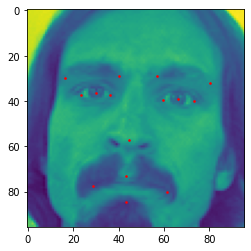

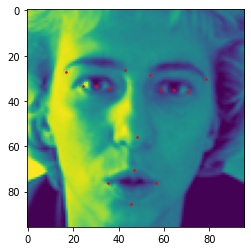

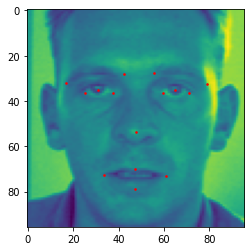

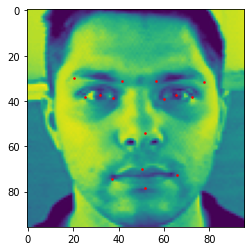

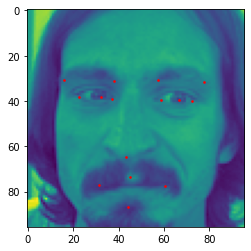

In [324]:
import matplotlib.pyplot as plt
import numpy as np

def show_face(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

for i in range(5):
  image = df.iloc[i, -1].split(" ")
  image = np.asarray(image)
  image = image.astype('float').reshape(96, 96)

  face_elements = df.iloc[i, :-1]
  face_elements = np.asarray(face_elements)
  face_elements = face_elements.astype('float').reshape(-1, 2)
  
  show_face(image, face_elements)

In [32]:
  image = df.iloc[i, -1].split(" ")
  image = np.asarray(image)
  image = image.astype('int').reshape(96, 96)

  face_elements = df.iloc[i, :-1]
  face_elements = np.asarray(face_elements)
  face_elements = face_elements.astype('float').reshape(-1, 2)

7049
2140


In [0]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

class FaceKeypointsDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
       self.df = pd.read_csv(csv_file).dropna()
       self.transform = transform

    def __len__(self):
      #zwraca długość zbioru danych
        return len(self.df)

    def __getitem__(self, idx):
        #funkcja zwraca pojedyncza obserwacje
        #nalezy oddzielic punkty od obrazka
        #nalezy przeksztalcic wczytane dane do odpowiedniego formatu np string na tablice int
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = df.iloc[idx, -1].split(" ")
        image = np.asarray(image)
        image = image.astype('int').reshape(96, 96)
        keypoints = df.iloc[idx, :-1]
        keypoints = np.asarray(keypoints)
        keypoints = keypoints.astype('float').reshape(-1, 2)

        sample = {'image': image, 'keypoints': keypoints}

        if self.transform:
          sample = self.transform(sample)

        return sample

In [0]:
#przykładowe wczytanie danych do dataset
face_dataset = FaceKeypointsDataset(csv_file='training.csv')

#sprawdzenie czy każdy obrazek ma taką samą wielkość
for i in range(len(face_dataset)):
  if face_dataset[i]["image"].shape != (96, 96):
    print("Wrong image shape in row " + str(i) + " which is:" + str(face_dataset[i]["image"].shape))

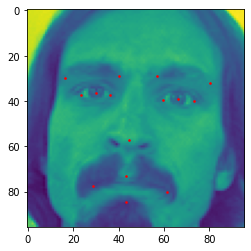

In [330]:
  show_face(face_dataset[0]["image"], face_dataset[0]["keypoints"])

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, ):
        super(MLP, self).__init__()
        
        self.layer1 = nn.Linear(input_size, 1024)
        self.layer2 = nn.Linear(1024, 256)
        self.output = nn.Linear(256, output_size)
        
    def forward(self, x):
        x = x.view(-1, 9216).float()     
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)    
        return x

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

test_size = 0.3
batch_size = 16
    
len_face_dataset = len(face_dataset)
indices = list(range(len_face_dataset))
np.random.shuffle(indices)
split = int(np.floor(test_size * len_face_dataset))
train_idx, test_idx = indices[split:], indices[:split]
    

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(face_dataset, batch_size= batch_size,
                                               sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size,
                                               sampler = test_sampler)
    

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(9216, 30)
model = model.to(device)

In [0]:
from torch import optim
criterion =  nn.MSELoss() #MSE
optimizer =  optim.SGD(model.parameters(), lr=0.000001)

In [0]:
def train(train_loader, test_loader, model, criterion, optimizer, 
          n_epochs=50):
  
    # # initialize tracker for minimum validation loss
    # valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        
        train_loss = 0.0
        test_loss = 0.0

       
        model.train() #training
        for batch in train_loader:
            
            optimizer.zero_grad()
            output = model(batch['image'].to(device))


            loss = criterion(output, batch['keypoints'].to(device).view(-1, 30).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

       
        model.eval() #  evaluation
        for batch in test_loader:
            output = model(batch['image'].to(device))
            
            loss = criterion(output, batch['keypoints'].to(device).view(-1, 30).float())
             
            test_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \ Test Loss: {:.6f}'
              .format(epoch+1, train_loss, test_loss))
            
    return train_losses, test_losses 

In [337]:
train_losses, test_losses = train(train_loader, test_loader,
                                   model, criterion, optimizer,
                                   n_epochs=50)

Epoch: 1 	Training Loss: 265.128732 \ Test Loss: 156.551569
Epoch: 2 	Training Loss: 155.769087 \ Test Loss: 145.546251
Epoch: 3 	Training Loss: 147.949110 \ Test Loss: 140.436525
Epoch: 4 	Training Loss: 141.579080 \ Test Loss: 139.786742
Epoch: 5 	Training Loss: 135.695914 \ Test Loss: 138.508182
Epoch: 6 	Training Loss: 132.150721 \ Test Loss: 128.172977
Epoch: 7 	Training Loss: 126.914724 \ Test Loss: 131.586079
Epoch: 8 	Training Loss: 122.433696 \ Test Loss: 120.463337
Epoch: 9 	Training Loss: 120.018436 \ Test Loss: 123.587153
Epoch: 10 	Training Loss: 116.651109 \ Test Loss: 119.501696
Epoch: 11 	Training Loss: 112.579833 \ Test Loss: 119.153340
Epoch: 12 	Training Loss: 109.839323 \ Test Loss: 112.094254
Epoch: 13 	Training Loss: 106.865916 \ Test Loss: 110.128070
Epoch: 14 	Training Loss: 103.462586 \ Test Loss: 111.839766
Epoch: 15 	Training Loss: 100.530094 \ Test Loss: 107.153613
Epoch: 16 	Training Loss: 98.356043 \ Test Loss: 101.126580
Epoch: 17 	Training Loss: 96.51408

In [0]:
#SPRAWDZIĆ CZY PUNKTY SĄ BLISKIE - ZWIZUALIZOWAĆ

Białe punkty na wykresie poniżej pokazują wartości rzeczywiste, zaś czerwone - wartości przewidywane.

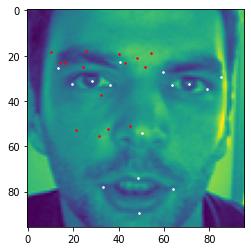

In [348]:
for batch in test_loader:
  output = model(batch['image'][0].to(device))
  output = output.view(-1, 2).cpu().detach().numpy()
  image = batch['image'][0]
  labels = batch['keypoints'][0]
  plt.imshow(image)
  plt.scatter(output[:, 0], output[:, 1], s=10, marker='.', c='red')
  plt.scatter(labels[:, 0], labels[:, 1], s=10, marker='.', c='white')
  break